# Data Engineering

In [1]:
# https://stackoverflow.com/a/50650918
# https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset
! pip install kaggle imblearn xgboost lightgbm shap > /dev/null
! pip install fastapi nest-asyncio pyngrok uvicorn > /dev/null

# from google.colab import files
# files.upload() # to upload kaggle.json

# ! mkdir -p ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d rupakroy/online-payments-fraud-detection-dataset

# ! rm -rvf ~/.kaggle/
# ! rm -rvf /root/.kaggle/
# ! rm -rvf ./kaggle.json

! unzip ./online-payments-fraud-detection-dataset.zip
! rm -vf ./online-payments-fraud-detection-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset
License(s): CC-BY-NC-SA-4.0
 99% 176M/178M [00:01<00:00, 103MB/s] 
100% 178M/178M [00:01<00:00, 109MB/s]
Archive:  ./online-payments-fraud-detection-dataset.zip
  inflating: PS_20174392719_1491204439457_log.csv  
removed './online-payments-fraud-detection-dataset.zip'


In [2]:
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.width', 3000)
sns.set()

def adjoin(*objs, **kwds):
    from pandas.io.formats.printing import adjoin as adj
    space = kwds.get('space', 8)
    reprs = [repr(obj).split('\n') for obj in objs]
    print(adj(space, *reprs), '\n\n')

In [3]:
df = pd.read_csv('./PS_20174392719_1491204439457_log.csv')
adjoin(df.head())

"""
adjoin(df['nameDest'].map(lambda x: x.startswith('M')).value_counts())

# All were fully false
# adjoin(df['nameDest'].map(lambda x: x.startswith('m')).value_counts())
# adjoin(df['nameOrig'].map(lambda x: x.startswith('M')).value_counts())
# adjoin(df['nameOrig'].map(lambda x: x.startswith('m')).value_counts())
adjoin(df[df['nameDest'].map(lambda x: x.startswith('M'))]['isFraud'].value_counts())

# No meaningful info on merchant transactions, hence drop them
df['toMerchant'] = df['nameDest'].map(lambda x: x.startswith('M'))
df = df[ ~df['toMerchant'] ].drop('toMerchant', axis=1)

# There is no longer any meaning to names
df = df.drop(['nameOrig', 'nameDest'], axis=1)
"""
df.info(verbose=True, show_counts=True)

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36  M1979787155             0.0             0.0        0               0
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72  M2044282225             0.0             0.0        0               0
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   C553264065             0.0             0.0        1               0
3     1  CASH_OUT    181.00   C840083671          181.0            0.00    C38997010         21182.0             0.0        1               0
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86  M1230701703             0.0             0.0        0               0 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Co

     amount  isFraud  toMerc  diffOrig  diffDest
0   9839.64    False    True  -9839.64       0.0
1   1864.28    False    True  -1864.28       0.0
2    181.00     True   False   -181.00       0.0
3    181.00     True   False   -181.00  -21182.0
4  11668.14    False    True -11668.14       0.0 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   amount    6362620 non-null  float64
 1   isFraud   6362620 non-null  bool   
 2   toMerc    6362620 non-null  bool   
 3   diffOrig  6362620 non-null  float64
 4   diffDest  6362620 non-null  float64
dtypes: bool(2), float64(3)
memory usage: 157.8 MB


<Axes: >

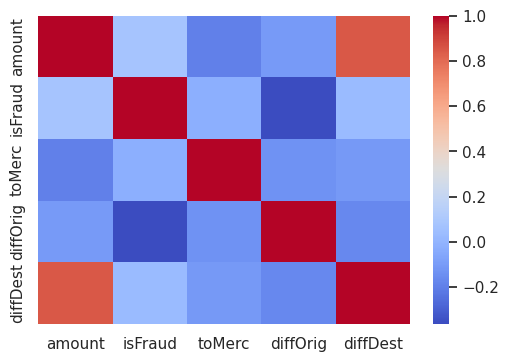

In [4]:
# After the first development, shap values indicated 'type' to be non important
# If destination is merchant, transaction is never fraud, so retain feature
# adjoin(df['type'].value_counts())
# df['type'] = df['type'].map({'CASH_IN': 1, 'CASH_OUT': 2, 'DEBIT': 3, 'PAYMENT': 4, 'TRANSFER': 5,})
df['toMerc'] = df['nameDest'].map(lambda x: x.startswith('M')).astype(bool)
df['isFraud'] = df['isFraud'].astype( bool)
df['diffOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['diffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

cols_to_drop = [
    'oldbalanceOrg', 'newbalanceOrig', 'nameOrig',
    'nameDest', 'oldbalanceDest', 'newbalanceDest',
    'isFlaggedFraud', 'step', 'type',
]

df = df.drop(cols_to_drop, axis=1)
adjoin(df.head())
df.info(verbose=True, show_counts=True)
plt.figure(figsize = (6, 4))
sns.heatmap(data = df.corr(), cmap = "coolwarm")

In [5]:
# X_old = df.drop('isFraud', axis=1)
X_new = df.drop('isFraud', axis=1).copy()
y_new = df['isFraud']

# from sklearn.preprocessing import MinMaxScaler
# # MinMaxScaler returns a numpy array
# # X_new = will cause variable redefinition
# # X_new.loc[:,:] will do smart allocation to a df view
# X_new.loc[:,:] = MinMaxScaler().fit_transform(X_old, y_new)

# Will organize by the df index automatically
# X_old.join(X_new, lsuffix='_old', rsuffix='_new').sample(5)

"To avoid this we can simply use a pipeline with MMScaler + LGBMClassifier"

# Address class imbalance
# Over-sampling with SMOTE - for testing
from imblearn.over_sampling import SMOTE
X_smote, y_smote = SMOTE().fit_resample(X_new,y_new)

# Random Under Sampling - for training
from imblearn.under_sampling import RandomUnderSampler
X_under, y_under = RandomUnderSampler().fit_resample(X_new,y_new)
adjoin(y_new.value_counts(), y_smote.value_counts(), y_under.value_counts())

isFraud                          isFraud                          isFraud                  
False    6354407                 False    6354407                 False    8213            
True        8213                 True     6354407                 True     8213            
Name: count, dtype: int64        Name: count, dtype: int64        Name: count, dtype: int64 




# Model Selection

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

class DummyEstimator(BaseEstimator):
    def transform(self): pass
    def fit(self): pass
    def score(self): pass

pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estim', DummyEstimator()),
])

In [7]:
# https://stackoverflow.com/a/15599032
# https://datascience.stackexchange.com/a/52030
# SVC vs NuSVC vs LinearSVC
# LinearSVC (~0.5sec) SVC ( ~3sec ) and NuSVC ( ~20sec ) are compute intensive

# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
# https://www.kaggle.com/code/paweljankiewicz/lightgbm-with-sklearn-pipelines
# https://goodboychan.github.io/python/datacamp/machine_learning/2020/07/07/03-Using-XGBoost-in-pipelines.html

grid_params = {
    'estim': [
        LogisticRegression(),
        RandomForestClassifier(),
        ExtraTreesClassifier(),
        NuSVC(probability=True), # LinearSVC(), SVC()
        XGBClassifier(),
        LGBMClassifier(verbose= -100),
    ]
}

# https://towardsdatascience.com/6-useful-metrics-to-evaluate-binary-classification-models-55fd1fed6a20
grid_kwargs = dict(
    estimator=pipe,
    param_grid=grid_params,
    cv=5, verbose=3, n_jobs=-1,
    return_train_score=True,
    # refit=False,
    # Best model for overall score -> LGBMClassifier
    # scoring = ['f1', 'precision', 'recall', 'roc_auc', 'accuracy']
    scoring='precision', # Best model for prec -> RandomForest
)

# For fraud detection, we have to consider customer satisfaction
# Hence minimize false positives -> Maximize Precision
# refit=False: We will have to manually refit best model in case of multimetric

In [8]:
"# Under Sampled Data (16k records) for training"
X, y = X_under.to_numpy(), y_under.to_numpy()

# Temporarily Suppressing Warnings
# https://stackoverflow.com/a/32389270

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipeGrid = GridSearchCV(**grid_kwargs).fit(X, y)

# For multimetric evaluation only
# For single metric, we can choose best estimator
# results = pd.DataFrame(pipeGrid.cv_results_)

# adjoin(
#     results.filter(like="rank_test_").sum(axis=1),
#     results.filter(like="split").dropna(axis=1).mean(axis=1)
# )

# results.columns
# https://datascience.stackexchange.com/a/6855
print(pipeGrid.best_estimator_)
adjoin(pd.DataFrame(pipeGrid.cv_results_), '')
X_under.columns

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('scale', MinMaxScaler()), ('estim', NuSVC(probability=True))])
   mean_fit_time  std_fit_time  mean_score_time  std_score_time                                        param_estim                                             params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  split0_train_score  split1_train_score  split2_train_score  split3_train_score  split4_train_score  mean_train_score  std_train_score          
0       0.107558      0.006480         0.009974        0.004046                               LogisticRegression()                    {'estim': LogisticRegression()}                0.0                0.0           0.961753                1.0  ...         0.592351        0.483854                2            0.782978            0.787451            0.962438            0.984101            0.984370          0.900268    

Index(['amount', 'toMerc', 'diffOrig', 'diffDest'], dtype='object')

# Model Testing Metrics

In [9]:
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score

# Testing with N records from 12M oversampled records
N = 20000
tmp_df = pd.concat([X_smote, y_smote], axis=1).sample(N)
y_true = tmp_df['isFraud']
y_pred = pipeGrid.predict(tmp_df.drop('isFraud', axis=1).to_numpy())

Accuracy:  0.8429
Precision:  0.9788
Recall:  0.6995
ROC_AUC_score:  0.8422


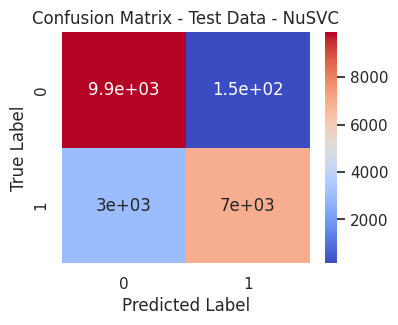

In [10]:
print(f"Accuracy: {(y_pred == y_true).mean(): .4f}")
print(f"Precision: {precision_score(y_true, y_pred): .4f}")
print(f"Recall: {recall_score(y_true, y_pred): .4f}")
print(f"ROC_AUC_score: {roc_auc_score(y_true, y_pred): .4f}")

# NuSVC is too compute intensive
# But gives good Precision of 98%
# With Lower Recall 70% and Accuracy 85%
plt.figure(figsize = (4,3))
plt.title('Confusion Matrix - Test Data - NuSVC')
sns.heatmap(confusion_matrix(tmp_df['isFraud'], y_pred), annot=True, cmap='coolwarm')
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

In [11]:
# Model Interpretability
# feat_imp = model.feature_importances_
# https://stackoverflow.com/a/49818693

# Cannot use feature importances if best estim is SVM
try:
    feat_imp = pipeGrid.best_estimator_.named_steps["estim"].feature_importances_
    pd.DataFrame(feat_imp, index=X_under.columns).plot.bar()
except AttributeError:
    print("'NuSVC' object has no attribute 'feature_importances_'")

'NuSVC' object has no attribute 'feature_importances_'


In [12]:
# https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Iris%20classification%20with%20scikit-learn.html#Support-vector-machine-with-a-radial-basis-function-kernel
# https://stackoverflow.com/questions/60649581/gridsearchcv-uses-predict-or-predict-proba

import shap
# shap_values = shap.Explainer(pipeGrid.predict, tmp_df.drop('isFraud', axis=1))

# Use in case of NuSVC, init with probability=True
shap_sample = shap.sample(tmp_df.drop('isFraud', axis=1), 100)
shap_values = shap.KernelExplainer(pipeGrid.predict_proba, shap_sample)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    values = shap_values((tmp_df.drop('isFraud', axis=1).sample(100)))

# Use only if Explainer() was used; not for KernelExplainer
# shap.plots.bar(values)
values.values[:, :, 1][:10]

  0%|          | 0/100 [00:00<?, ?it/s]

array([[-0.01708141,  0.08500346,  0.45035097, -0.02093186],
       [ 0.00539094,  0.10571845,  0.38211185, -0.00172518],
       [-0.04783537,  0.02000686,  0.51935451,  0.00581517],
       [-0.16672397,  0.03189484, -0.08111631, -0.2847339 ],
       [ 0.05036316,  0.0640389 , -0.20662596,  0.04311797],
       [-0.04616139,  0.01227635,  0.58905005, -0.05782383],
       [ 0.02518627,  0.04111709, -0.3744409 ,  0.01500712],
       [ 0.01533768, -0.24262279, -0.27199564,  0.01326574],
       [-0.00116627,  0.02301253, -0.53907546,  0.01941727],
       [ 0.01727624,  0.03177322, -0.46594872,  0.0214754 ]])

Accuracy:  0.9678
Precision:  0.9575
Recall:  0.9788
ROC_AUC_score:  0.9679


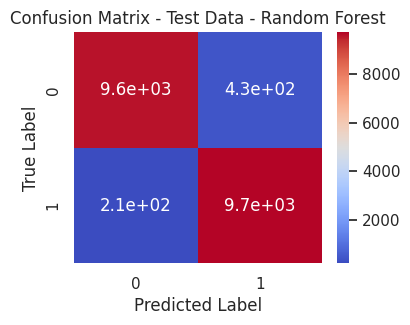

In [14]:
# Testing shap values for RandomForest
# Training takes less than 1% of time as compared to NuSVC
# NuSVC gives 98% Precision, RF gives 95%
y_pred = RandomForestClassifier().fit(X_under, y_under).predict(tmp_df.drop('isFraud', axis=1))

print(f"Accuracy: {(y_pred == y_true).mean(): .4f}")
print(f"Precision: {precision_score(y_true, y_pred): .4f}")
print(f"Recall: {recall_score(y_true, y_pred): .4f}")
print(f"ROC_AUC_score: {roc_auc_score(y_true, y_pred): .4f}")

plt.figure(figsize = (4,3))
plt.title('Confusion Matrix - Test Data - Random Forest')
sns.heatmap(confusion_matrix(tmp_df['isFraud'], y_pred), annot=True, cmap='coolwarm')
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

# feat_imp = model.feature_importances_
# pd.DataFrame(feat_imp, index=X_under.columns).plot.bar();

# API Development & Testing

In [ ]:
# https://stackoverflow.com/a/63833779
# https://stackoverflow.com/a/78178013
# https://dashboard.ngrok.com/tunnels/authtokens

# Data Schema and app setup

from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)

class InputData(BaseModel):
    amount: float
    toMerc: bool
    oldOrg: float
    newOrg: float
    oldDst: float
    newDst: float

In [ ]:
# Endpoints

# We will set post method for root for prediction
# go to homeurl/docs for SwaggerUI documentation
@app.get('/')
async def root():
    return {'message': 'Hello, World!'}

@app.post("/")
async def predict(input: InputData):
    record = np.array([[
        input.amount,
        input.toMerc,
        input.newOrg - input.oldOrg,
        input.newDst - input.oldDst,
    ]], dtype='float')

    result = bool(pipeGrid.predict(record)[0])
    return {'isFraud': result}

# Deployment

def start_server():
    import nest_asyncio
    import uvicorn
    from pyngrok import ngrok

    # Paste ngrok auth token here before deployment
    ngrok.set_auth_token("")
    print('Public URL:', ngrok.connect(8000).public_url) # Get URL from tunnel
    nest_asyncio.apply()
    uvicorn.run(app, port=8000, timeout_keep_alive=15)


if __name__ == "__main__":
    try:
        start_server()
    except KeyboardInterrupt:
        print("\nKilled the server!")

In [ ]:
# Testing the API, run from another script

import requests

# Example input data
input_data = {
    "amount": 987895.45,
    "toMerc": False,
    "oldOrg": 100,
    "newOrg": 100,
    "oldDst": 100,
    "newDst": 78548500,
}

# Send POST request to your FastAPI app
# Copy Public NGROK url here before running
response = requests.post("", json=input_data)

# Print the prediction returned by the API
print(response.json())